# __Import__

In [36]:
import pandas as pd
import numpy as np
import glob
import os
import random
import json 
import matplotlib.pyplot as plt
import seaborn as sns


with open('../config/config.json', 'r') as file:
    config = json.load(file)

# __Data Loading__

In [37]:
def load_data(path, k=100):
    random.seed(42)
    all_files = glob.glob(os.path.join(path, "*.csv"))
    samples = random.sample(all_files, k=k)

    li = []

    for i, filename in enumerate(samples):
        df = pd.read_csv(filename, sep=";")
        df["Sensor"] = i
        df = df.set_index(keys="Sensor", drop=True)
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=False)

    return df


df = load_data(path = config["data_path"], k=3)

In [38]:
df.columns, df.shape

(Index(['YYYY', 'MM', 'DD', 'DOY', '2m_temp_max', '2m_temp_mean', '2m_temp_min',
        '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u',
        '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe',
        'surf_net_solar_rad_max', 'surf_net_solar_rad_mean',
        'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press',
        'total_et', 'prec', 'volsw_123', 'volsw_4'],
       dtype='object'),
 (42732, 25))

# __Null Value Analysis__

In [39]:
df.isna().sum()

YYYY                       0
MM                         0
DD                         0
DOY                        0
2m_temp_max                0
2m_temp_mean               0
2m_temp_min                0
2m_dp_temp_max             0
2m_dp_temp_mean            0
2m_dp_temp_min             0
10m_wind_u                 0
10m_wind_v                 0
fcst_alb                   0
lai_high_veg               0
lai_low_veg                0
swe                        0
surf_net_solar_rad_max     0
surf_net_solar_rad_mean    0
surf_net_therm_rad_max     0
surf_net_therm_rad_mean    0
surf_press                 0
total_et                   0
prec                       0
volsw_123                  0
volsw_4                    0
dtype: int64

No missing values

# __Statistical Analysis__

__Correlations__

<Axes: >

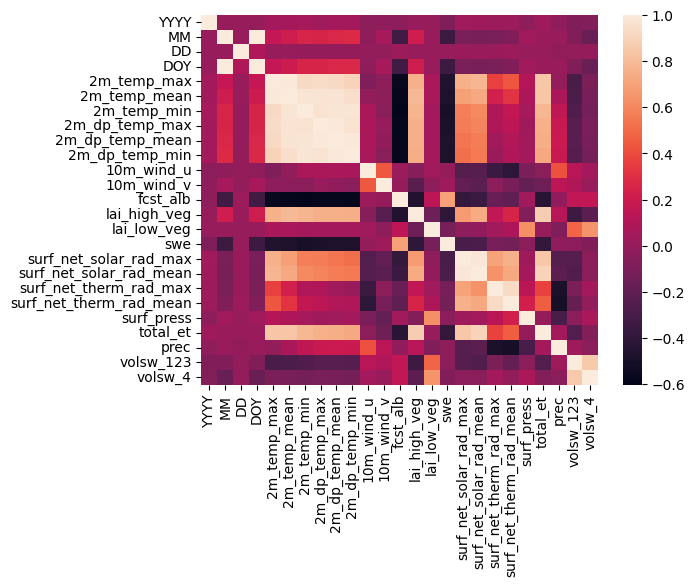

In [40]:
sns.heatmap(df.corr())

## __Data Distributions__

### __Precipitation by Sensors from 1981 - 2019__

/var/folders/6l/6v6rmk9141928hf9tsw7qqxw0000gn/T/ipykernel_30801/111590394.py:8: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(yearly_sensors, x="YYYY", y="prec", hue="Sensor", palette=["#d1d6de"], legend=None, linewidth=0.5) # ["#808080"] , "#dcdfe3"


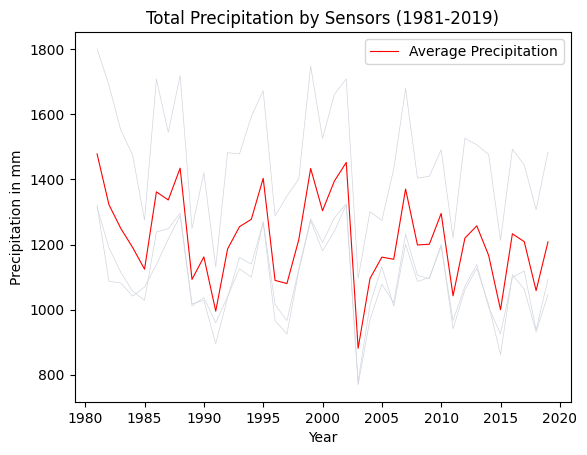

In [41]:
# sensor prec by year
yearly_sensors = df.groupby(["YYYY","Sensor"]).sum()
yearly_sensors = yearly_sensors["prec"].reset_index()

# average sensor prec by year
yearly_sensor_avg = df.groupby(["YYYY","Sensor"])["prec"].sum().groupby("YYYY").mean().reset_index()

sns.lineplot(yearly_sensors, x="YYYY", y="prec", hue="Sensor", palette=["#d1d6de"], legend=None, linewidth=0.5) # ["#808080"] , "#dcdfe3"
sns.lineplot(yearly_sensor_avg, x="YYYY", y="prec", color="red", label="Average Precipitation", legend=True, linewidth=0.8)
plt.ylabel("Precipitation in mm")
plt.xlabel("Year")
plt.title("Total Precipitation by Sensors (1981-2019)")
plt.show()

### __Average Precipiation by Month (1981 - 2019)__

average per month across the sensors

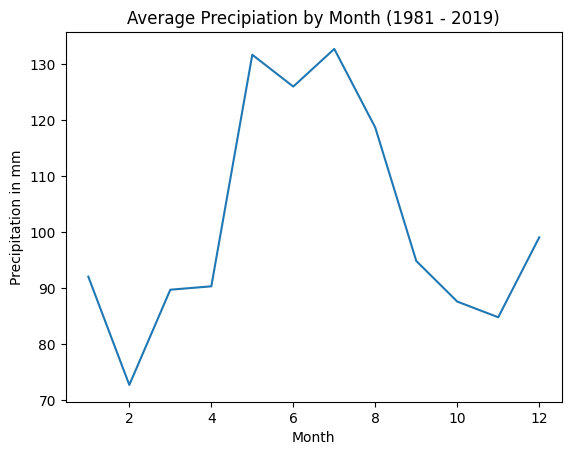

In [42]:
monthly_avg = df.groupby(['YYYY', 'MM', 'Sensor'])["prec"].sum().groupby("MM").mean()

plt.plot(monthly_avg)
plt.title("Average Precipiation by Month (1981 - 2019)")
plt.ylabel("Precipitation in mm")
plt.xlabel("Month")
plt.show()

### __Total Precipiation by Year (1981 - 2019)__
total prec of all sensors by year

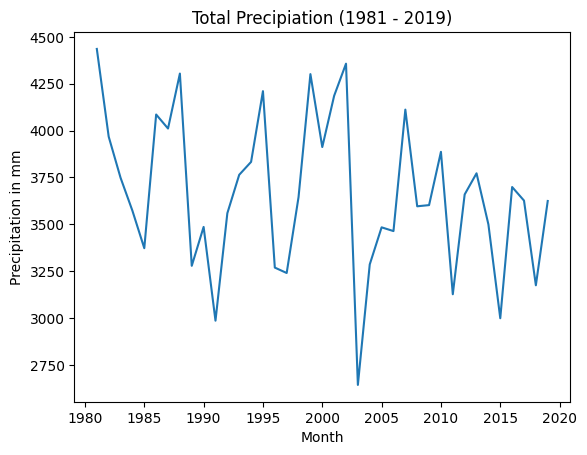

In [43]:
yearly_sum = df.groupby(['YYYY', 'MM'])["prec"].sum()
yearly_sum_avg = yearly_sum.groupby('YYYY').sum()

plt.plot(yearly_sum_avg)
plt.title("Total Precipiation (1981 - 2019)")
plt.ylabel("Precipitation in mm")
plt.xlabel("Month")
plt.show()

# __Preprocessing__

## __Cyclic Encoding__

In [44]:
df['MM_sin'] = np.sin(2 * np.pi * df['MM']/12.0)
df['MM_cos'] = np.cos(2 * np.pi * df['MM']/12.0)

df['DOY_sin'] = np.sin(2 * np.pi * df['DOY']/365.0)
df['DOY_cos'] = np.cos(2 * np.pi * df['DOY']/365.0)

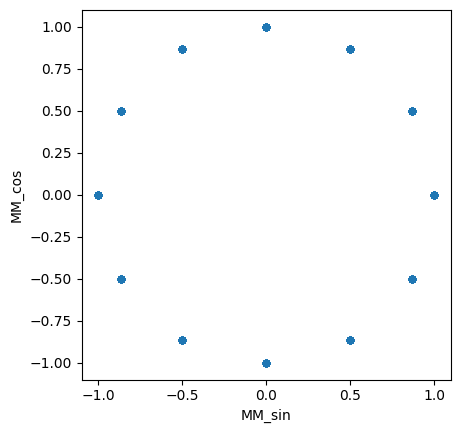

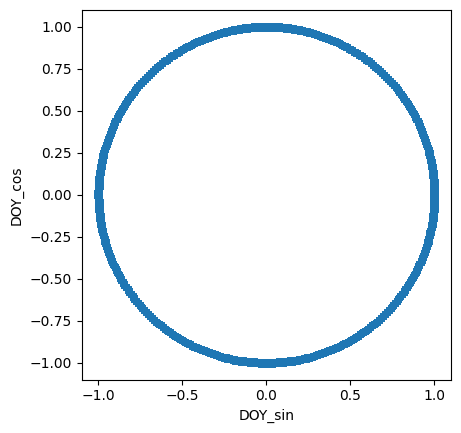

In [45]:
ax = df.plot.scatter('MM_sin', 'MM_cos').set_aspect('equal')
ax = df.plot.scatter('DOY_sin', 'DOY_cos').set_aspect('equal')

## __Set Multi-Index__

In [46]:
df = df.reset_index()
df = df.set_index([df["YYYY"].rename("Year"), df["MM"].rename("Month"), df["DD"].rename("Day"), df["Sensor"]], drop=True)
df = df.drop(columns=["YYYY", "MM", "DD", "DOY", "Sensor"], axis=1)
df = df.sort_index()
df.head()

2m_temp_max  2m_temp_mean  2m_temp_min  2m_dp_temp_max  \
Year Month Day Sensor                                                           
1981 1     1   0               1.4           0.1         -2.0            -0.8   
               1               1.4           0.1         -2.1            -0.9   
               2               0.0          -1.5         -2.9            -1.1   
           2   0               1.2          -0.4         -2.0            -0.3   
               1               1.0          -0.5         -2.1            -0.4   

                       2m_dp_temp_mean  2m_dp_temp_min  10m_wind_u  \
Year Month Day Sensor                                                
1981 1     1   0                  -2.8            -4.6         5.9   
               1                  -2.9            -4.6         5.6   
               2                  -2.8            -4.2         4.4   
           2   0                  -2.2            -4.7         5.0   
               1                  -2.6            -4.8         4.7   

                       10m_wind_v  fcst_alb  lai_high_veg  ...  \
Year Month Day Sensor                                      ...   
1981 1     1   0              0.5      0.22           1.3  ...   
               1              0.4      0.23           1.5  ...   
               2              1.1      0.34           1.4  ...   
           2   0              1.8      0.32           1.3  ...   
               1              1.3      0.29           1.5  ...   

                       surf_net_therm_rad_mean  surf_press  total_et   prec  \
Year Month Day Sensor                                                         
1981 1     1   0                            40       94065      0.63   4.76   
               1                            39       94529      0.76   5.47   
               2                            34       92738      0.30   7.11   
           2   0                            16       93986      0.31  13.29   
               1                            19       94516      0.35  12.66   

                       volsw_123  volsw_4  MM_sin    MM_cos   DOY_sin  \
Year Month Day Sensor                                                   
1981 1     1   0            0.48     0.49     0.5  0.866025  0.017213   
               1            0.40     0.40     0.5  0.866025  0.017213   
               2            0.41     0.41     0.5  0.866025  0.017213   
           2   0            0.48     0.49     0.5  0.866025  0.034422   
               1            0.40     0.40     0.5  0.866025  0.034422   

                        DOY_cos  
Year Month Day Sensor            
1981 1     1   0       0.999852  
               1       0.999852  
               2       0.999852  
           2   0       0.999407  
               1       0.999407  

[5 rows x 25 columns]

## __Scale Data__

In [51]:
from sklearn.preprocessing import StandardScaler
exclude_columns = ['MM_sin', 'MM_cos', 'DOY_sin','DOY_cos']

# Columns to scale
scale_columns = df.columns.difference(exclude_columns)

scaler = StandardScaler()
df[scale_columns] = scaler.fit_transform(df[scale_columns])
df

2m_temp_max  2m_temp_mean  2m_temp_min  2m_dp_temp_max  \
Year Month Day Sensor                                                           
1981 1     1   0         -1.264145     -1.024458    -0.863470       -1.033581   
               1         -1.264145     -1.024458    -0.877633       -1.048464   
               2         -1.435887     -1.236073    -0.990938       -1.078231   
           2   0         -1.288680     -1.090588    -0.863470       -0.959164   
               1         -1.313214     -1.103814    -0.877633       -0.974047   
...                            ...           ...          ...             ...   
2019 12    30  1         -0.981998     -1.249299    -1.217547       -1.509848   
               2         -0.687584     -0.931877    -0.863470       -1.152647   
           31  0         -0.773455     -0.945103    -0.806817       -0.959164   
               1         -0.859326     -0.998006    -0.863470       -1.093114   
               2         -0.687584     -0.918651    -0.863470       -0.825214   

                       2m_dp_temp_mean  2m_dp_temp_min  10m_wind_u  \
Year Month Day Sensor                                                
1981 1     1   0             -1.001454       -0.900608    2.941831   
               1             -1.016043       -0.900608    2.775072   
               2             -1.001454       -0.844866    2.108036   
           2   0             -0.913916       -0.914543    2.441554   
               1             -0.972274       -0.928478    2.274795   
...                                ...             ...         ...   
2019 12    30  1             -1.541272       -1.541636   -0.504523   
               2             -1.614221       -1.792473   -0.560109   
           31  0             -1.132761       -1.207186   -0.059832   
               1             -1.147351       -1.123574    0.273686   
               2             -1.132761       -1.235057   -0.337764   

                       10m_wind_v  fcst_alb  lai_high_veg  ...  \
Year Month Day Sensor                                      ...   
1981 1     1   0         0.254362  0.497195     -1.141170  ...   
               1         0.164902  0.635387     -0.866567  ...   
               2         0.791122  2.155504     -1.003868  ...   
           2   0         1.417343  1.879119     -1.141170  ...   
               1         0.970042  1.464541     -0.866567  ...   
...                           ...       ...           ...  ...   
2019 12    30  1         0.522742 -0.331960     -0.866567  ...   
               2        -0.014018 -0.884730     -0.866567  ...   
           31  0         0.075442 -0.884730     -1.141170  ...   
               1         0.075442 -0.331960     -0.866567  ...   
               2        -0.014018 -0.884730     -0.866567  ...   

                       surf_net_therm_rad_mean  surf_press  total_et  \
Year Month Day Sensor                                                  
1981 1     1   0                     -0.445689    0.564655 -0.788612   
               1                     -0.491468    0.946276 -0.689774   
               2                     -0.720358   -0.526748 -1.039508   
           2   0                     -1.544364    0.499681 -1.031905   
               1                     -1.407030    0.935584 -1.001494   
...                                        ...         ...       ...   
2019 12    30  1                      0.378316    2.057418 -1.229581   
               2                      0.332538   -0.025048 -1.191566   
           31  0                      0.652985    1.387114 -1.237184   
               1                      0.195204    1.952966 -1.221978   
               2                      0.652985   -0.060413 -1.221978   

                           prec  volsw_123   volsw_4    MM_sin    MM_cos  \
Year Month Day Sensor                                                      
1981 1     1   0       0.281138   1.589484  1.616046  0.715312  1.225336   
               1       0.421833  -

# __Save Data__

In [52]:
df.to_csv("../output/data.csv", sep=";", index=True)